In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from os import listdir
from os.path import exists

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score, classification_report

In [3]:
import cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [5]:
path_csv = './data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
path_img = './data/Flipkart/Images'
path_img_little = './data/Flipkart/ImagesLittles'

In [6]:
data = pd.read_csv(path_csv)

In [7]:
# Récupère le noeud à la profondeur level
# (ou la feuille si level va trop profond)
def get_from_tree(tree, level):
    if len(tree) > level:
        return tree[level]
    else:
        return tree[-1]

In [8]:
data['product_category_list'] = data['product_category_tree'].apply(lambda e : e[2:-2]).str.split(' >> ')

In [9]:
def show_representation(data, cat, limit=None, X_tsne=None, title=''):
    if X_tsne is None:
        tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random')
        X_tsne = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
    df_tsne["class"] = cat.reset_index(drop=True)
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette=sns.color_palette('tab10', n_colors=nb_cat_little), s=50,
        data=df_tsne,
        legend="brief")

    plt.title(title, fontsize = 14, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 14, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 14, fontweight = 'bold')
    plt.legend(prop={'size': 8}) 

    plt.show()
    
    return X_tsne

In [10]:
level = 1

In [11]:
nb_min_elements = 2

In [12]:
data_final = data[['image', 'product_category_list']].copy()
data_final.columns = ['img', 'cat_lst']
data_final['img'] = path_img+'/'+data_final['img']

data_final['cat'] = data_final['cat_lst'].apply(lambda tree : get_from_tree(tree, level))

list_labels = list(data_final['cat'].value_counts().index)
data_final['label'] = data_final['cat'].apply(lambda e : list_labels.index(e))

In [13]:
nb_cat_little = (data_final['cat'].value_counts() > nb_min_elements).sum()
nb_cat = len(list_labels)

In [14]:
print("Nombre de catégories total :", nb_cat)
print("Nombre de catégories de plus de", nb_min_elements, "élément :", nb_cat_little)

Nombre de catégories total : 62
Nombre de catégories de plus de 2 élément : 41


In [15]:
data_little = data_final.loc[data_final['cat'].isin(list_labels[:nb_cat_little])].copy().reset_index()

In [16]:
data_little

,index,img,cat_lst,cat,label
0,0,./data/Flipkart/Images/55b85ea15a1536d46b7190a...,"[Home Furnishing, Curtains & Accessories, Curt...",Curtains,17
1,5,./data/Flipkart/Images/893aa5ed55f7cff2eccea77...,"[Watches, Wrist Watches, Maserati Time Wrist W...",Wrist Watches,0
2,6,./data/Flipkart/Images/f355cc1ccb08bd0d283ed97...,"[Watches, Wrist Watches, Camerii Wrist Watches]",Wrist Watches,0
3,7,./data/Flipkart/Images/dd0e3470a7e6ed76fd69c2d...,"[Watches, Wrist Watches, T STAR Wrist Watches]",Wrist Watches,0
4,8,./data/Flipkart/Images/41384da51732c0b4df3de8f...,"[Watches, Wrist Watches, Alfajr Wrist Watches]",Wrist Watches,0
...,...,...,...,...,...
762,1045,./data/Flipkart/Images/958f54f4c46b53c8a0a9b81...,"[Baby Care, Baby & Kids Gifts, Stickers, Oren ...",Stickers,18
763,1046,./data/Flipkart/Images/fd6cbcc22efb6b761bd564c...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Stickers,18
764,1047,./data/Flipkart/Images/5912e037d12774bb73a2048...,"[Baby Care, Baby & Kids Gifts, Stickers, Uberl...",Stickers,18
765,1048,./data/Flipkart/Images/c3edc504d1b4f0ba6224fa5...,"[Baby Care, Baby & Kids Gifts, Stickers, Wallm...",Stickers,18


# Mon CODE

In [17]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as VGG16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [18]:
input_shape = VGG16().input_shape
input_shape

(None, 224, 224, 3)

In [19]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

## Conversion

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
def preprocess_image(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = img_to_array(image)
    image = preprocess_input(image)
    return image

In [25]:
def cat_to_label(l):
    return np.argmax(l)

In [26]:
data_X = list(data_little["img"].apply(preprocess_image))
data_X = np.asarray(data_X).astype(np.float32)

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [27]:
data_y = to_categorical(data_little['label'], num_classes=nb_cat_little)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.33, stratify=data_y)

In [29]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

# Dropout(0.5)(x)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 460)               28851660  
                                                                 
 dropout (Dropout)           (None, 460)               0         
                                                                 
 dense_1 (Dense)             (None, 184)               84824     
                                                                 
 dense_2 (Dense)             (None, 46)                8510      
                                                        

In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=3, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/20
13/13 [==============================] - 19s 1s/step - loss: 10.1190 - accuracy: 0.3488 - val_loss: 3.7304 - val_accuracy: 0.6117
Epoch 2/20
13/13 [==============================] - 16s 1s/step - loss: 1.9271 - accuracy: 0.7366 - val_loss: 2.8640 - val_accuracy: 0.6602
Epoch 3/20
13/13 [==============================] - 16s 1s/step - loss: 0.4203 - accuracy: 0.9244 - val_loss: 2.6445 - val_accuracy: 0.6699
Epoch 4/20
13/13 [==============================] - 16s 1s/step - loss: 0.1751 - accuracy: 0.9488 - val_loss: 2.3287 - val_accuracy: 0.7282
Epoch 5/20
13/13 [==============================] - 16s 1s/step - loss: 0.1131 - accuracy: 0.9707 - val_loss: 2.2118 - val_accuracy: 0.7282
Epoch 6/20
13/13 [==============================] - 16s 1s/step - loss: 0.0709 - accuracy: 0.9805 - val_loss: 2.5629 - val_accuracy: 0.7087
Epoch 7/20
13/13 [==============================] - 16s 1s/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 2.9394 - val_accuracy: 0.6893
Epoch 8/20
13/13 [=

In [32]:
pred_train = model.predict(X_train)

17/17 [==============================] - 16s 920ms/step


In [33]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

0.9597371407950746

In [34]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [35]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.99      0.99      0.99        93
                                  Combos       0.96      1.00      0.98        43
                             Coffee Mugs       1.00      1.00      1.00        42
                               Bed Linen       0.95      0.97      0.96        40
                                 Routers       1.00      0.94      0.97        32
                              Showpieces       0.82      0.78      0.80        23
                             USB Gadgets       0.78      0.91      0.84        23
                                  Ethnic       0.96      0.96      0.96        23
                               Batteries       1.00      1.00      1.00        15
                          Woks & Kadhais       0.94      1.00      0.97        15
                              Bath Linen       0.75      0.92      0.83        13
               

In [36]:
pred_test = model.predict(X_test)

8/8 [==============================] - 9s 1s/step


In [37]:
balanced_accuracy_score([cat_to_label(e) for e in y_test], [cat_to_label(e) for e in pred_test])

0.4443581780538302

In [38]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.98      1.00      0.99        47
                                  Combos       0.95      0.95      0.95        21
                             Coffee Mugs       0.95      0.95      0.95        21
                               Bed Linen       0.77      0.85      0.81        20
                                 Routers       1.00      0.75      0.86        16
                              Showpieces       0.24      0.33      0.28        12
                             USB Gadgets       0.33      0.64      0.44        11
                                  Ethnic       0.50      0.36      0.42        11
                               Batteries       0.70      1.00      0.82         7
                          Woks & Kadhais       0.78      1.00      0.88         7
                              Bath Linen       0.33      0.29      0.31         7
               

In [39]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

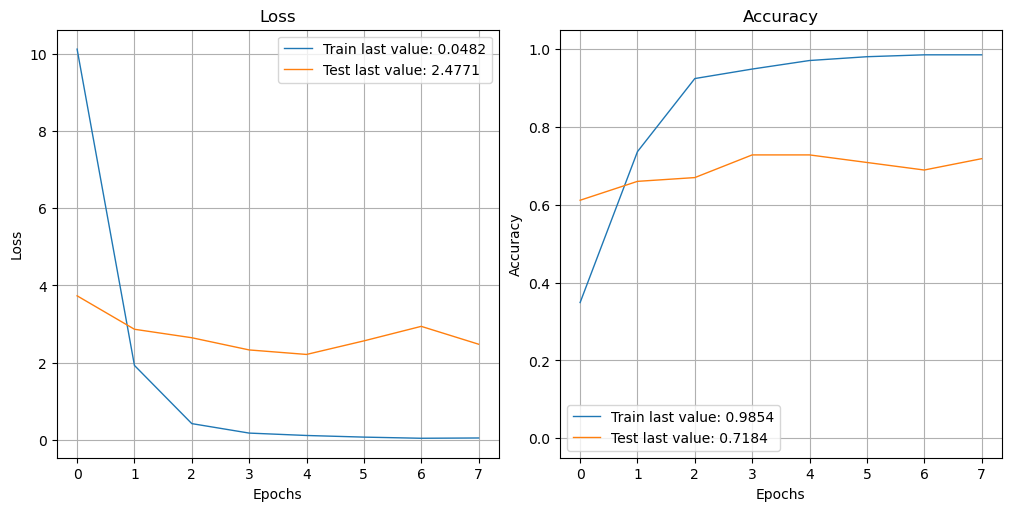

In [40]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

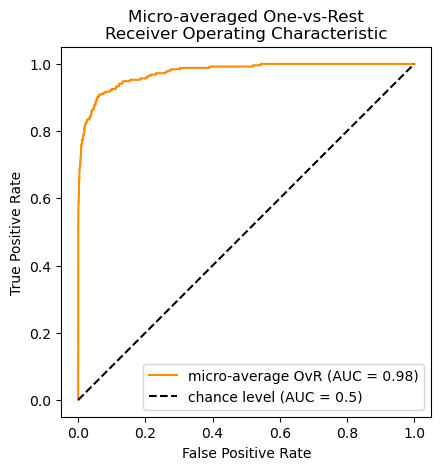

In [42]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [43]:
@interact
def show_ROC_mono(class_of_interest = labels_little):
    class_id = labels_little.index(class_of_interest)
    RocCurveDisplay.from_predictions(
        y_test[:, class_id],
        pred_test[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
    )

    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{class_of_interest} vs Rest ROC curves")
    plt.legend()
    return plt.show()

interactive(children=(Dropdown(description='class_of_interest', options=('Wrist Watches', 'Combos', 'Coffee Mu…

# Data Augmentation

In [44]:
tmp = data_final['cat'].value_counts()

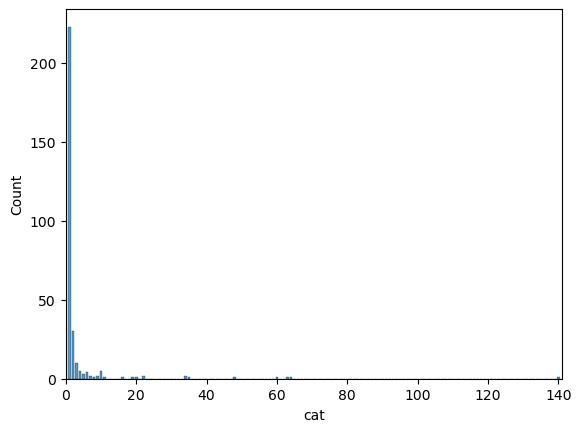

In [45]:
fig, ax = plt.subplots()
sns.histplot(tmp, shrink=.8, discrete=True, ax=ax)
ax.set_xlim(0,max(tmp)+1)
plt.show()

In [46]:
def show_from_cv2(img):
    plt.figure(figsize=(6, 6))
    
    plt.imshow(img)
    
    ax = plt.gca()
    plt.axis("off")
    return plt.show()

In [47]:
path = data_little['img'].iloc[0]

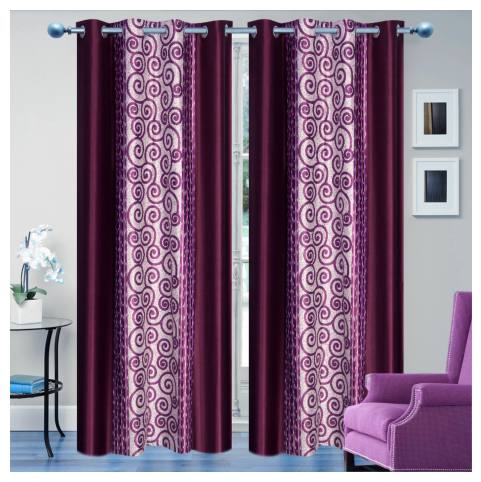

In [48]:
img = cv2.imread(path)
img = cv2.resize(img, dsize=(1000, 1000), interpolation=cv2.INTER_CUBIC)
show_from_cv2(img)

In [49]:
@interact
def change_hue(new=widgets.IntSlider(min=0, max=360, step=1, value=0)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    hnew = np.mod(h + new, 180).astype(h.dtype)
    hsv_new = cv2.merge([hnew,s,v])
    img_new = cv2.cvtColor(hsv_new, cv2.COLOR_HSV2RGB)
    return show_from_cv2(img_new)

interactive(children=(IntSlider(value=0, description='new', max=360), Output()), _dom_classes=('widget-interac…

In [50]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
 
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

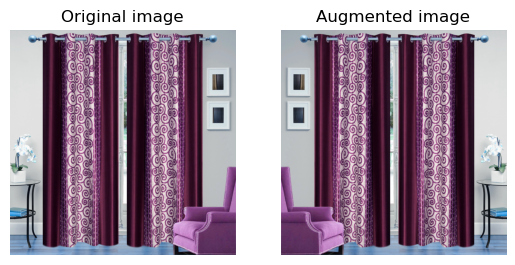

In [51]:
flipped = tf.image.flip_left_right(img)
visualize(img, flipped)

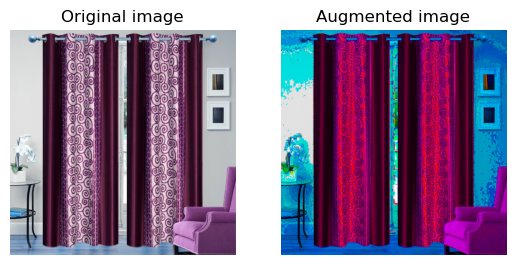

In [52]:
saturated = tf.image.adjust_saturation(img, 256)
visualize(img, saturated)

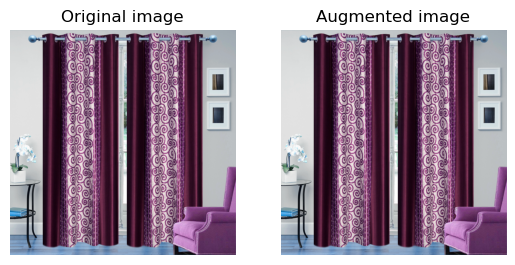

In [53]:
tmp = tf.image.adjust_brightness(img, 0)
visualize(img, tmp)

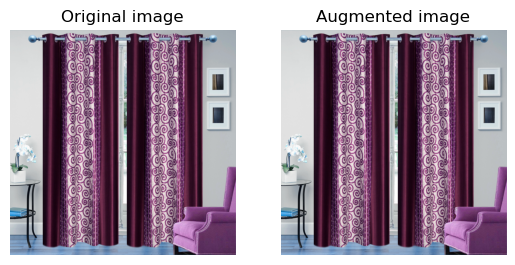

In [54]:
tmp = tf.image.adjust_contrast(img, 1)
visualize(img, tmp)

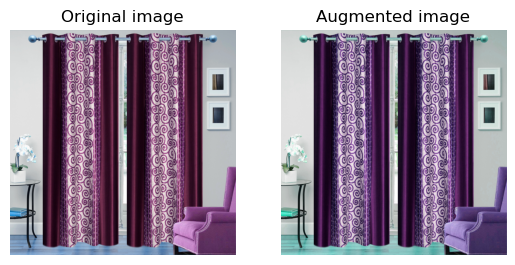

In [55]:
tmp = tf.image.adjust_hue(img, -0.1)
visualize(img, tmp)

In [56]:
i = 1

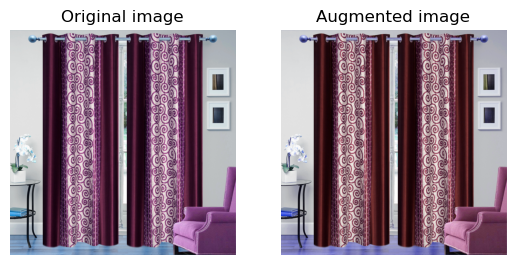

In [57]:
bright = tf.image.stateless_random_hue(img, 0.1, (i, 0))
visualize(img, bright)
i += 1

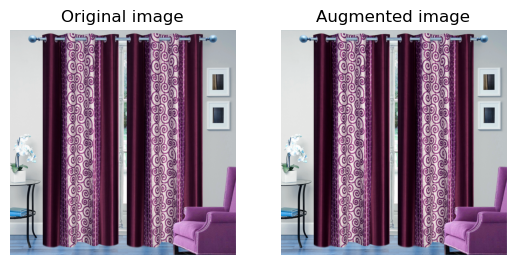

In [58]:
bright = tf.image.stateless_random_contrast(img, 1, 1.1, (0, 2))
visualize(img, bright)

In [59]:
import albumentations as A

In [60]:
transform = A.Compose([
    #A.RandomCrop(width=256, height=256, p=1),
    #A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    #A.CLAHE(),
    #A.RandomRotate90(),
    #A.Transpose(),
    A.ShiftScaleRotate(
        shift_limit=0.02,
        scale_limit=[-0.2, 0.02],
        rotate_limit=0,
        p=.75,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_CONSTANT,
        value=(255, 255, 255),),
    A.SafeRotate(
        limit=10,
        interpolation=cv2.INTER_LANCZOS4,
        border_mode=cv2.BORDER_CONSTANT,
        value=(255, 255, 255),),
    #A.OpticalDistortion(),
    #A.RandomSnow(),
    #A.RandomShadow(),
    #A.RandomBrightnessContrast(p=.75),
    A.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.15,
        p=0.75),
    A.Blur(blur_limit=1),
    A.GaussNoise(p=0.75),
    #A.augmentations.geometric.resize.LongestMaxSize(max(input_shape[1:3])),
])

In [61]:
image = cv2.imread(data_little['img'].iloc[0])

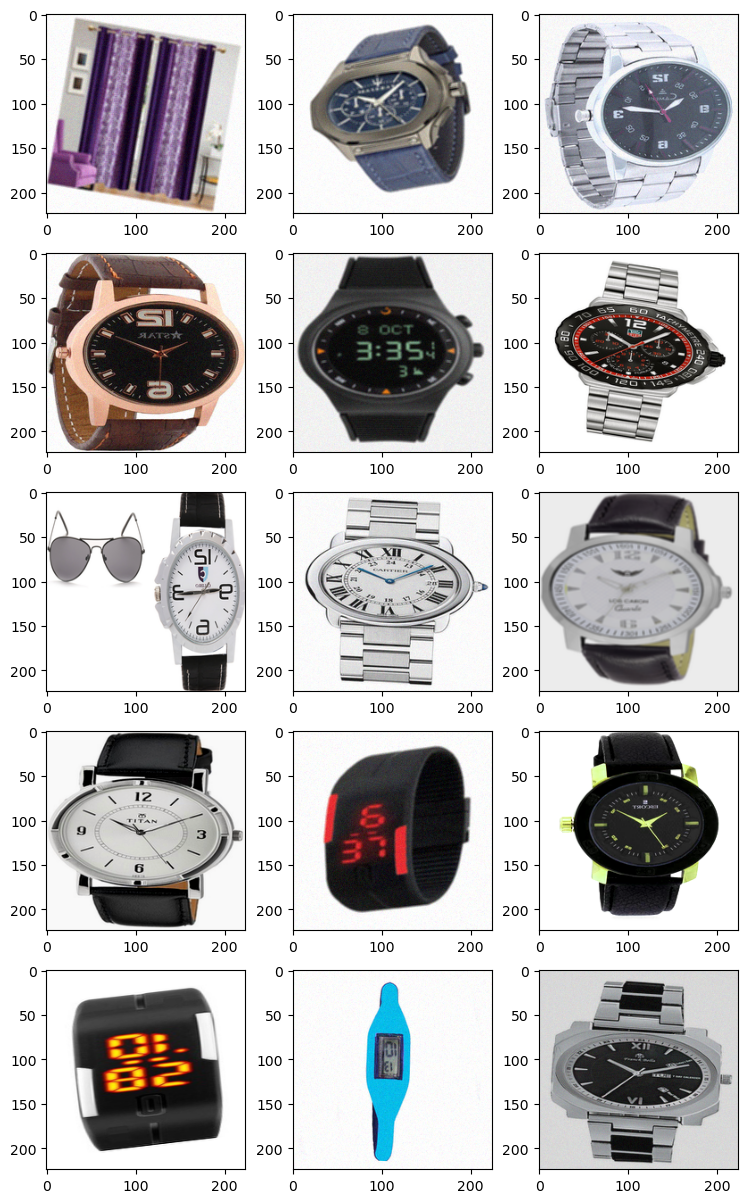

In [62]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))
for i in range(15):
    image = load_img(data_little['img'].iloc[i], target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    transformed = transform(image=image)
    ax[i // 3, i % 3].imshow(transformed["image"])
plt.show()

In [63]:
def preprocess_image_augmented(path):
    image = load_img(path, target_size=input_shape[1:3], interpolation='lanczos')
    image = np.array(image)
    image = transform(image=image)['image']
    image = preprocess_input(image)
    return image

In [64]:
X_train_img, X_test_img, y_train_label, y_test_label = train_test_split(
    data_little['img'],
    data_little['label'],
    test_size=0.33,
    stratify=data_little['label'])

In [65]:
X_test = list(X_test_img.apply(preprocess_image))
X_test = np.asarray(X_test).astype(np.float32)

In [66]:
y_test = to_categorical(y_test_label, num_classes=nb_cat_little)

In [67]:
df = pd.DataFrame([X_train_img, y_train_label]).T
df

,img,label
449,./data/Flipkart/Images/144a5e05bd6e69535c53366...,0
176,./data/Flipkart/Images/8f41774c16a931d71fcf01f...,7
441,./data/Flipkart/Images/97fba8a02361aa56eaa9fa5...,0
86,./data/Flipkart/Images/f8794f7a06b530782c66f7c...,2
224,./data/Flipkart/Images/2f40e01331bc00216d147d4...,7
...,...,...
307,./data/Flipkart/Images/d376da2235096f74600d842...,1
615,./data/Flipkart/Images/414d2065e1aed847064bcf1...,3
460,./data/Flipkart/Images/87e0ba259a84a10580bd659...,0
640,./data/Flipkart/Images/de47d0cc0c4875fb97530f6...,6


In [68]:
df['label'].value_counts()

0     93
1     43
2     42
3     40
4     32
5     23
6     23
7     23
9     15
8     15
10    13
11    13
12    11
16     7
17     7
13     7
18     7
15     7
14     7
19     6
20     6
21     5
23     5
22     5
24     4
25     4
27     4
26     4
35     3
30     3
28     3
29     3
33     3
34     3
36     2
41     2
45     2
43     2
42     2
31     2
38     2
39     2
44     2
37     2
32     2
40     2
Name: label, dtype: int64

In [69]:
X_augmented = []
y_augmented = []

but = 25
for i, n in df['label'].value_counts().items():
    if n >= but:
        continue
    
    a_faire = but - n
    liste_images = df.loc[df['label']==i, 'img']
    
    for path in np.random.choice(liste_images, a_faire):
        img_tmp = preprocess_image_augmented(path)
        X_augmented.append(img_tmp)
        y_augmented.append(i)

X_augmented = np.asarray(X_augmented).astype(np.float32)

C:\ProgramData\Anaconda3\envs\Tensorflow\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [70]:
for i in range(0):
    X_tmp = df["img"].apply(preprocess_image_augmented)
    X_tmp = np.asarray(list(X_tmp)).astype(np.float32)
    
    X_augmented = np.concatenate((X_augmented, X_tmp))
    
    y_tmp = df["label"].copy()
    
    y_augmented = np.concatenate((y_augmented, y_tmp))

In [71]:
X_train = df["img"].apply(preprocess_image)

In [72]:
X_train = np.asarray(list(X_train)).astype(np.float32)

In [73]:
X_train.shape

(513, 224, 224, 3)

In [74]:
X_train = np.concatenate((X_train, X_augmented))

In [75]:
X_train.shape

(1275, 224, 224, 3)

In [76]:
len(df["label"])

513

In [77]:
y_train = np.concatenate((df["label"], y_augmented))

In [78]:
y_train.shape

(1275,)

In [79]:
y_train = to_categorical(y_train, num_classes=nb_cat_little)

In [80]:
y_train.shape

(1275, 46)

In [81]:
base_model = VGG16(include_top=False, input_shape=input_shape[1:])
base_model.trainable = False

In [82]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(nb_cat_little*10, activation='relu')
drop_out = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(nb_cat_little*4, activation='relu')
prediction_layer = layers.Dense(nb_cat_little, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_out,
    dense_layer_2,
    prediction_layer
])

# Dropout(0.5)(x)

In [83]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy',  min_delta = 0.02, mode='max', patience=3, restore_best_weights=True)
es = EarlyStopping(monitor='val_loss', min_delta = 0.02, mode='min', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/20
32/32 [==============================] - 55s 2s/step - loss: 3.7869 - accuracy: 0.5412 - val_loss: 5.7274 - val_accuracy: 0.0549
Epoch 2/20
32/32 [==============================] - 46s 1s/step - loss: 0.3369 - accuracy: 0.9196 - val_loss: 2.2253 - val_accuracy: 0.5569
Epoch 3/20
32/32 [==============================] - 46s 1s/step - loss: 0.2228 - accuracy: 0.9520 - val_loss: 1.6059 - val_accuracy: 0.6784
Epoch 4/20
32/32 [==============================] - 57s 2s/step - loss: 0.0964 - accuracy: 0.9765 - val_loss: 2.4643 - val_accuracy: 0.6039
Epoch 5/20
32/32 [==============================] - 53s 2s/step - loss: 0.1148 - accuracy: 0.9716 - val_loss: 2.1280 - val_accuracy: 0.6745
Epoch 6/20
32/32 [==============================] - 54s 2s/step - loss: 0.0851 - accuracy: 0.9794 - val_loss: 2.4415 - val_accuracy: 0.6549


In [84]:
pred_train = model.predict(X_train)

40/40 [==============================] - 50s 1s/step


In [85]:
balanced_accuracy_score([cat_to_label(e) for e in pred_train], [cat_to_label(e) for e in y_train])

0.953279522604334

In [86]:
labels_little = data_little.sort_values('label')['cat'].drop_duplicates().to_list()

In [87]:
print(classification_report(
    [cat_to_label(e) for e in y_train],
    [cat_to_label(e) for e in pred_train],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.99      1.00      0.99        93
                                  Combos       1.00      1.00      1.00        43
                             Coffee Mugs       1.00      1.00      1.00        42
                               Bed Linen       0.93      1.00      0.96        40
                                 Routers       0.94      1.00      0.97        32
                              Showpieces       0.96      1.00      0.98        25
                             USB Gadgets       0.64      1.00      0.78        25
                                  Ethnic       1.00      0.96      0.98        25
                               Batteries       1.00      1.00      1.00        25
                          Woks & Kadhais       1.00      1.00      1.00        25
                              Bath Linen       0.43      1.00      0.60        25
               

In [88]:
pred_test = model.predict(X_test)

8/8 [==============================] - 10s 1s/step


In [89]:
balanced_accuracy_score([cat_to_label(e) for e in y_test], [cat_to_label(e) for e in pred_test])

0.5925442311311876

In [90]:
print(classification_report(
    [cat_to_label(e) for e in y_test],
    [cat_to_label(e) for e in pred_test],
    target_names=labels_little,
    zero_division=0))

                                          precision    recall  f1-score   support

                           Wrist Watches       0.92      1.00      0.96        47
                                  Combos       1.00      1.00      1.00        21
                             Coffee Mugs       0.95      1.00      0.98        21
                               Bed Linen       0.63      0.85      0.72        20
                                 Routers       0.93      0.88      0.90        16
                              Showpieces       0.33      0.33      0.33        12
                             USB Gadgets       0.71      0.45      0.56        11
                                  Ethnic       0.75      0.27      0.40        11
                               Batteries       1.00      1.00      1.00         7
                          Woks & Kadhais       0.58      1.00      0.74         7
                              Bath Linen       0.31      0.57      0.40         7
               

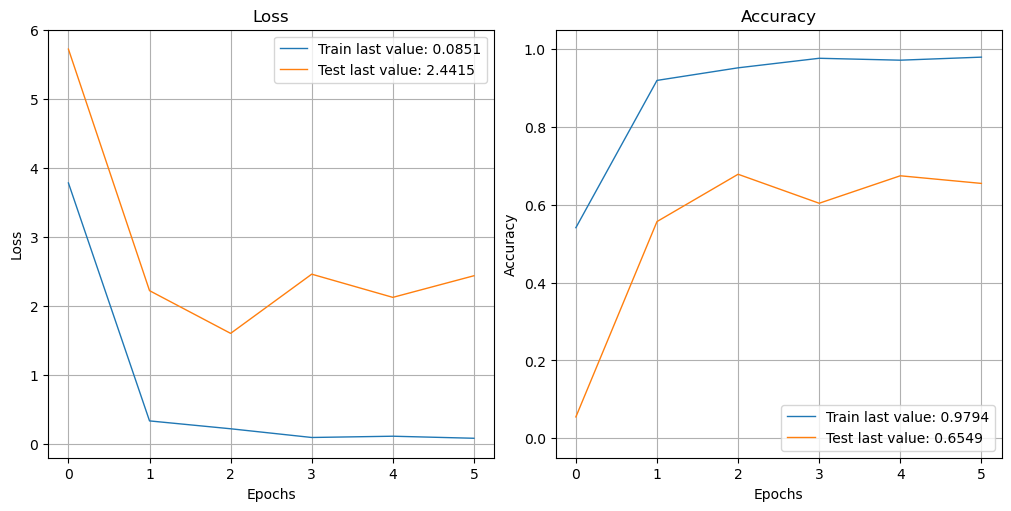

In [91]:
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

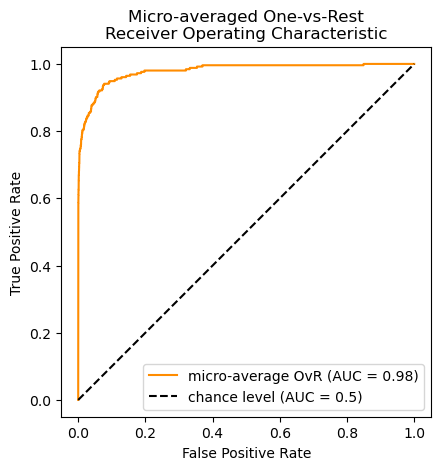

In [92]:
RocCurveDisplay.from_predictions(
    y_test.ravel(),
    pred_test.ravel(),
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()